# Hi :)

----

# Import libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Initialization

In [2]:
# Scaler
scaler= StandardScaler()

# Dataset and DataLoader
class CNNFeatureDataset(Dataset):
    def __init__(self, X, y):
        self.X= torch.tensor(X, dtype= torch.float32)
        self.y= torch.tensor(y, dtype= torch.long)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.network= nn.Sequential(
            nn.Conv1d(1, 16, kernel_size= 2),  # output: [batch, 16, 2]
            nn.ReLU(),
            nn.Flatten(),  # [batch, 16 * 2]
            nn.Linear(16 * 2, 32),
            nn.ReLU(),
            nn.Linear(32, 2)  # Binary classification (output: logits for 2 classes)
        )

    def forward(self, x):
        return self.network(x)

# ITG

# Loading the dataset

In [3]:
ITG_features_df= pd.read_csv('Dataset/ITG_features_df.csv')

# Boosting

In [4]:
# Step 1: Extract features and labels
X= ITG_features_df[['F1_sum_vector_magnitude', 'F2_orientation_angle', 'F3_std_magnitude']].values
y= ITG_features_df['Situation'].values

# Step 2: Encode labels ('Fall' → 1, 'Not Fall' → 0)
label_encoder= LabelEncoder()
y_encoded= label_encoder.fit_transform(y)

# Step 3: Split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded, test_size= 0.2, random_state= 48, stratify= y_encoded)

In [5]:
# Step 4: Train first model (SVM)
X_train1= X_train.copy()
X_train1= scaler.fit_transform(X_train1)
y_train1= y_train.copy()
svm= SVC(kernel= 'rbf', C= 100, gamma= 1, random_state= 48)
svm.fit(X_train1, y_train1)
y_pred1= svm.predict(X_train1)
errors1= (y_pred1 != y_train1).astype(int)
print('Done SVM')

Done SVM


In [6]:
# Step 5: Duplicate misclassified points
misclassified_indices= np.where(errors1 == 1)[0]

# Concatenate original data with misclassified points
X_train2= np.concatenate([X_train, X_train[misclassified_indices]], axis= 0)
y_train2= np.concatenate([y_train, y_train[misclassified_indices]], axis= 0)

In [7]:
# Step 6: Train second model (Random Forest)
rf= RandomForestClassifier(
    n_estimators= 200,
    max_depth= 10,
    min_samples_split= 2,
    min_samples_leaf= 1,
    random_state= 48
)
rf.fit(X_train2, y_train2)
y_pred2= rf.predict(X_train)
errors2= (y_pred2 != y_train).astype(int)
print('Done RF')

Done RF


In [8]:
# Step 7: Duplicate misclassified points
misclassified_indices= np.where(errors2 == 1)[0]

# Concatenate original data with misclassified points
X_train3= np.concatenate([X_train, X_train[misclassified_indices]], axis= 0)
y_train3= np.concatenate([y_train, y_train[misclassified_indices]], axis= 0)

In [9]:
# Step 8: Train third model (XGBoost)
xgb= XGBClassifier(
    n_estimators= 100,
    max_depth= 5,
    learning_rate= 0.1,
    subsample= 0.8,
    objective= 'binary:logistic',
    use_label_encoder= False,
    eval_metric= 'logloss',
    random_state= 48
)
xgb.fit(X_train3, y_train3)
y_pred3= xgb.predict(X_train)
errors3= (y_pred3 != y_train).astype(int)
print('Done XGB')

f:\Quera\Qvenv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:36:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done XGB


In [10]:
# Step 9: Duplicate misclassified points
misclassified_indices= np.where(errors3 == 1)[0]

# Concatenate original data with misclassified points
X_train4= np.concatenate([X_train, X_train[misclassified_indices]], axis= 0)
y_train4= np.concatenate([y_train, y_train[misclassified_indices]], axis= 0)

In [11]:
# Step 10: Train fourth model (CNN)
# Normalize features
scaler= StandardScaler()
X_train4= scaler.fit_transform(X_train4)
X_test= scaler.transform(X_test)

# Reshape to 1D-CNN format: (samples, channels= 1, timesteps= 3)
X_train4= X_train4.reshape((X_train4.shape[0], 1, X_train4.shape[1]))
X_test= X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Dataset and DataLoader
train_loader= DataLoader(CNNFeatureDataset(X_train4, y_train4), batch_size= 16, shuffle= True)
test_loader= DataLoader(CNNFeatureDataset(X_test, y_test), batch_size= 16)

# Train CNN
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= SimpleCNN().to(device)

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)

for epoch in range(20):
    model.train()
    total_loss= 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch= X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out= model(X_batch)
        loss= criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

print('Done CNN')
print('Done Boosting')

Epoch 1, Loss: 936.3963
Epoch 2, Loss: 928.3071
Epoch 3, Loss: 923.4886
Epoch 4, Loss: 921.3799
Epoch 5, Loss: 920.0897
Epoch 6, Loss: 918.3895
Epoch 7, Loss: 917.4171
Epoch 8, Loss: 915.7878
Epoch 9, Loss: 915.1055
Epoch 10, Loss: 913.6874
Epoch 11, Loss: 912.4357
Epoch 12, Loss: 911.7243
Epoch 13, Loss: 910.5432
Epoch 14, Loss: 908.5812
Epoch 15, Loss: 907.3540
Epoch 16, Loss: 906.2582
Epoch 17, Loss: 905.4432
Epoch 18, Loss: 904.4198
Epoch 19, Loss: 903.3477
Epoch 20, Loss: 901.7899
Done CNN
Done Boosting


Accuracy: 0.6077730090605628
Classification Report:
               precision    recall  f1-score   support

        Fall       0.62      0.55      0.59      2097
    Not Fall       0.60      0.66      0.63      2097

    accuracy                           0.61      4194
   macro avg       0.61      0.61      0.61      4194
weighted avg       0.61      0.61      0.61      4194



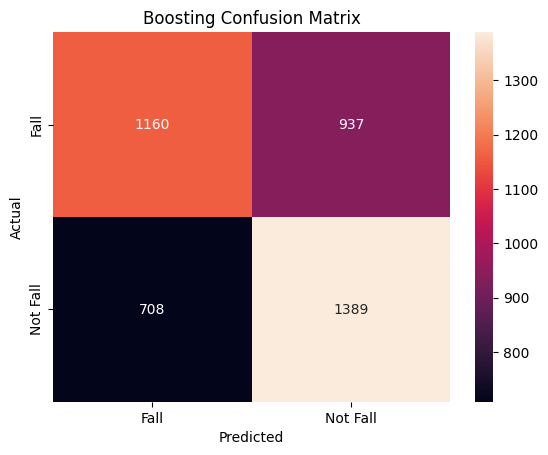

In [12]:
# Step 11: Evaluation
model.eval()
all_preds= []
all_true= []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch= X_batch.to(device)
        outputs= model(X_batch)
        _, predicted= torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(y_batch.numpy())

print("Accuracy:", accuracy_score(all_true, all_preds))
print("Classification Report:\n", classification_report(all_true, all_preds, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(all_true, all_preds)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

----

# Data Fusion

# Loading the dataset

In [13]:
KF_features_df= pd.read_csv('Dataset/KF_features_df.csv')

# Boosting

In [14]:
# Step 1: Extract features and labels
X= KF_features_df[['F1_sum_vector_magnitude', 'F2_orientation_angle', 'F3_std_magnitude']].values
y= KF_features_df['Situation'].values

# Step 2: Encode labels ('Fall' → 1, 'Not Fall' → 0)
label_encoder= LabelEncoder()
y_encoded= label_encoder.fit_transform(y)

# Step 3: Split dataset
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded, test_size= 0.2, random_state= 48, stratify= y_encoded)

In [15]:
# Step 4: Train first model (SVM)
X_train1= X_train.copy()
X_train1= scaler.fit_transform(X_train1)
y_train1= y_train.copy()
svm= SVC(kernel= 'rbf', C= 100, gamma= 1, random_state= 48)
svm.fit(X_train1, y_train1)
y_pred1= svm.predict(X_train1)
errors1= (y_pred1 != y_train).astype(int)
print('Done SVM')

Done SVM


In [16]:
# Step 5: Duplicate misclassified points
misclassified_indices= np.where(errors1 == 1)[0]

# Concatenate original data with misclassified points
X_train2= np.concatenate([X_train, X_train[misclassified_indices]], axis= 0)
y_train2= np.concatenate([y_train, y_train[misclassified_indices]], axis= 0)

In [17]:
# Step 6: Train second model (Random Forest)
rf= RandomForestClassifier(
    n_estimators= 200,
    max_depth= 10,
    min_samples_split= 2,
    min_samples_leaf= 1,
    random_state= 48
)
rf.fit(X_train2, y_train2)
y_pred2= rf.predict(X_train)
errors2= (y_pred2 != y_train).astype(int)
print('Done RF')

Done RF


In [18]:
# Step 7: Duplicate misclassified points
misclassified_indices= np.where(errors2 == 1)[0]

# Concatenate original data with misclassified points
X_train3= np.concatenate([X_train, X_train[misclassified_indices]], axis= 0)
y_train3= np.concatenate([y_train, y_train[misclassified_indices]], axis= 0)

In [19]:
# Step 8: Train third model (XGBoost)
xgb= XGBClassifier(
    n_estimators= 100,
    max_depth= 5,
    learning_rate= 0.1,
    subsample= 0.8,
    objective= 'binary:logistic',
    use_label_encoder= False,
    eval_metric= 'logloss',
    random_state= 48
)
xgb.fit(X_train3, y_train3)
y_pred3= xgb.predict(X_train)
errors3= (y_pred3 != y_train).astype(int)
print('Done XGB')

f:\Quera\Qvenv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:38:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Done XGB


In [20]:
# Step 9: Duplicate misclassified points
misclassified_indices= np.where(errors3 == 1)[0]

# Concatenate original data with misclassified points
X_train4= np.concatenate([X_train, X_train[misclassified_indices]], axis= 0)
y_train4= np.concatenate([y_train, y_train[misclassified_indices]], axis= 0)

In [21]:
# Step 10: Train fourth model (CNN)
# Normalize features
scaler= StandardScaler()
X_train4= scaler.fit_transform(X_train4)
X_test= scaler.transform(X_test)

# Reshape to 1D-CNN format: (samples, channels= 1, timesteps= 3)
X_train4= X_train4.reshape((X_train4.shape[0], 1, X_train4.shape[1]))
X_test= X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Dataset and DataLoader
train_loader= DataLoader(CNNFeatureDataset(X_train4, y_train4), batch_size= 16, shuffle= True)
test_loader= DataLoader(CNNFeatureDataset(X_test, y_test), batch_size= 16)

# Train CNN
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= SimpleCNN().to(device)

criterion= nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model.parameters(), lr= 0.001)

for epoch in range(20):
    model.train()
    total_loss= 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch= X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        out= model(X_batch)
        loss= criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch + 1}, Loss: {total_loss:.4f}")

print('Done CNN')
print('Done Boosting')

Epoch 1, Loss: 784.1271
Epoch 2, Loss: 765.8237
Epoch 3, Loss: 758.5576
Epoch 4, Loss: 754.5802
Epoch 5, Loss: 751.5204
Epoch 6, Loss: 747.3677
Epoch 7, Loss: 743.7753
Epoch 8, Loss: 740.8932
Epoch 9, Loss: 738.2743
Epoch 10, Loss: 735.4849
Epoch 11, Loss: 731.7811
Epoch 12, Loss: 730.2680
Epoch 13, Loss: 727.4176
Epoch 14, Loss: 726.7686
Epoch 15, Loss: 724.2688
Epoch 16, Loss: 721.6568
Epoch 17, Loss: 720.4636
Epoch 18, Loss: 718.4411
Epoch 19, Loss: 717.0686
Epoch 20, Loss: 715.6228
Done CNN
Done Boosting


Accuracy: 0.762279446828803
Classification Report:
               precision    recall  f1-score   support

        Fall       0.78      0.73      0.75      2097
    Not Fall       0.75      0.79      0.77      2097

    accuracy                           0.76      4194
   macro avg       0.76      0.76      0.76      4194
weighted avg       0.76      0.76      0.76      4194



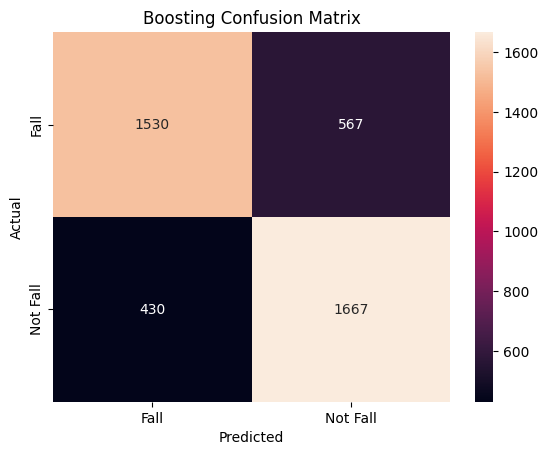

In [22]:
# Step 11: Evaluation
model.eval()
all_preds= []
all_true= []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch= X_batch.to(device)
        outputs= model(X_batch)
        _, predicted= torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(y_batch.numpy())

print("Accuracy:", accuracy_score(all_true, all_preds))
print("Classification Report:\n", classification_report(all_true, all_preds, target_names= label_encoder.classes_))

# Confusion Matrix
cm= confusion_matrix(all_true, all_preds)
sns.heatmap(cm, annot= True, fmt= 'd', xticklabels= label_encoder.classes_, yticklabels= label_encoder.classes_)
plt.title("Boosting Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()